# Loading the libraries

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


# Defining the functions(GENERAL)

## Parameter initialization

In [5]:
def params_init(seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(20,784) - 0.5
  b1 = np.random.rand(20,1) - 0.5
  W2 = np.random.rand(10,20) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

## Other generic functions egs-loss

In [6]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [7]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre)), axis = 0)
  return loss

## Forward pass

In [8]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

## Param update

In [9]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

# Back propagation

In [10]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [11]:
def batch_grad_descent(X,Y,iter, lr, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [12]:
_, _, _, _, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,5, 0.1, print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 74.06666666666666
Val accuracy: 74.04285714285714
Iteration: 2
Train accuracy: 81.43333333333334
Val accuracy: 81.6
Iteration: 3
Train accuracy: 84.46825396825398
Val accuracy: 84.62857142857143
Iteration: 4
Train accuracy: 86.27460317460317
Val accuracy: 86.24285714285715
Iteration: 5
Train accuracy: 87.45396825396826
Val accuracy: 87.2


# Weight perturbation

In [12]:
def WP(W1, b1, W2, b2, pert, lossBeforePert, X, y):
    m = y.shape[0] #m is the number of training examples
    Y = one_hot_encoding(y)
    dW1 = np.zeros_like(W1)
    lossAfterPertW1 = np.zeros_like(W1)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1pert = W1.copy()
            W1pert[i, j] += pert
            _, _, _, A2pert = forward(X, W1pert, b1, W2, b2)
            lossAfterPertW1[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW1 = 1/m * (lossAfterPertW1-lossBeforePert)/pert


    db1 = np.zeros_like(b1)
    lossAfterPertb1 = np.zeros_like(b1)
    for i in range(b1.shape[0]):
        b1pert = b1.copy()
        b1pert[i]+=pert
        _, _, _, A2pert = forward(X, W1, b1pert, W2, b2)
        lossAfterPertb1[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db1 = 1/m * (lossAfterPertb1-lossBeforePert)/pert

    
    dW2 = np.zeros_like(W2)
    lossAfterPertW2 = np.zeros_like(W2)
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2pert = W2.copy()
            W2pert[i, j] += pert
            _, _, _, A2pert = forward(X, W1, b1, W2pert, b2)
            lossAfterPertW2[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW2 = 1/m * (lossAfterPertW2-lossBeforePert)/pert


    db2 = np.zeros_like(b2)
    lossAfterPertb2 = np.zeros_like(b2)
    for i in range(b2.shape[0]):
        b2pert = b2.copy()
        b2pert[i]+=pert
        _, _, _, A2pert = forward(X, W1, b1, W2, b2pert)
        lossAfterPertb2[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db2 = 1/m * (lossAfterPertb2-lossBeforePert)/pert

    return dW1, db1, dW2, db2
            

In [13]:
def batch_grad_descentWP(X,Y,iter, lr, pert, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 
      print(f"BP Iter {i+1} -> sub iter {j} : {accuracy(predictions(A2), Y1)}", end = "\r", flush = True)

      #dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)
      loss = np.sum(crossEntropy(one_hot_encoding(Y1), A2))
      dW1, db1, dW2, db2 = WP(W1, b1, W2, b2, pert=pert, lossBeforePert=loss, X=X1, y=Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)


    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [15]:
pertList = [0.1, 0.01, 0.001, 0.0001]
trainAccWP = []
valAccWP = []
for pert in pertList:
    _, _, _, _, train_acc, val_acc, train_loss, val_loss, sum_weights = batch_grad_descentWP(x_train,y_train,5, 0.1, pert = pert, print_op=1);
    trainAccWP.append(train_acc)
    valAccWP.append(val_acc)

Params Initialised


KeyboardInterrupt: 

Text(0.5, 1.0, 'Accuracy vs epochs for different techiques')

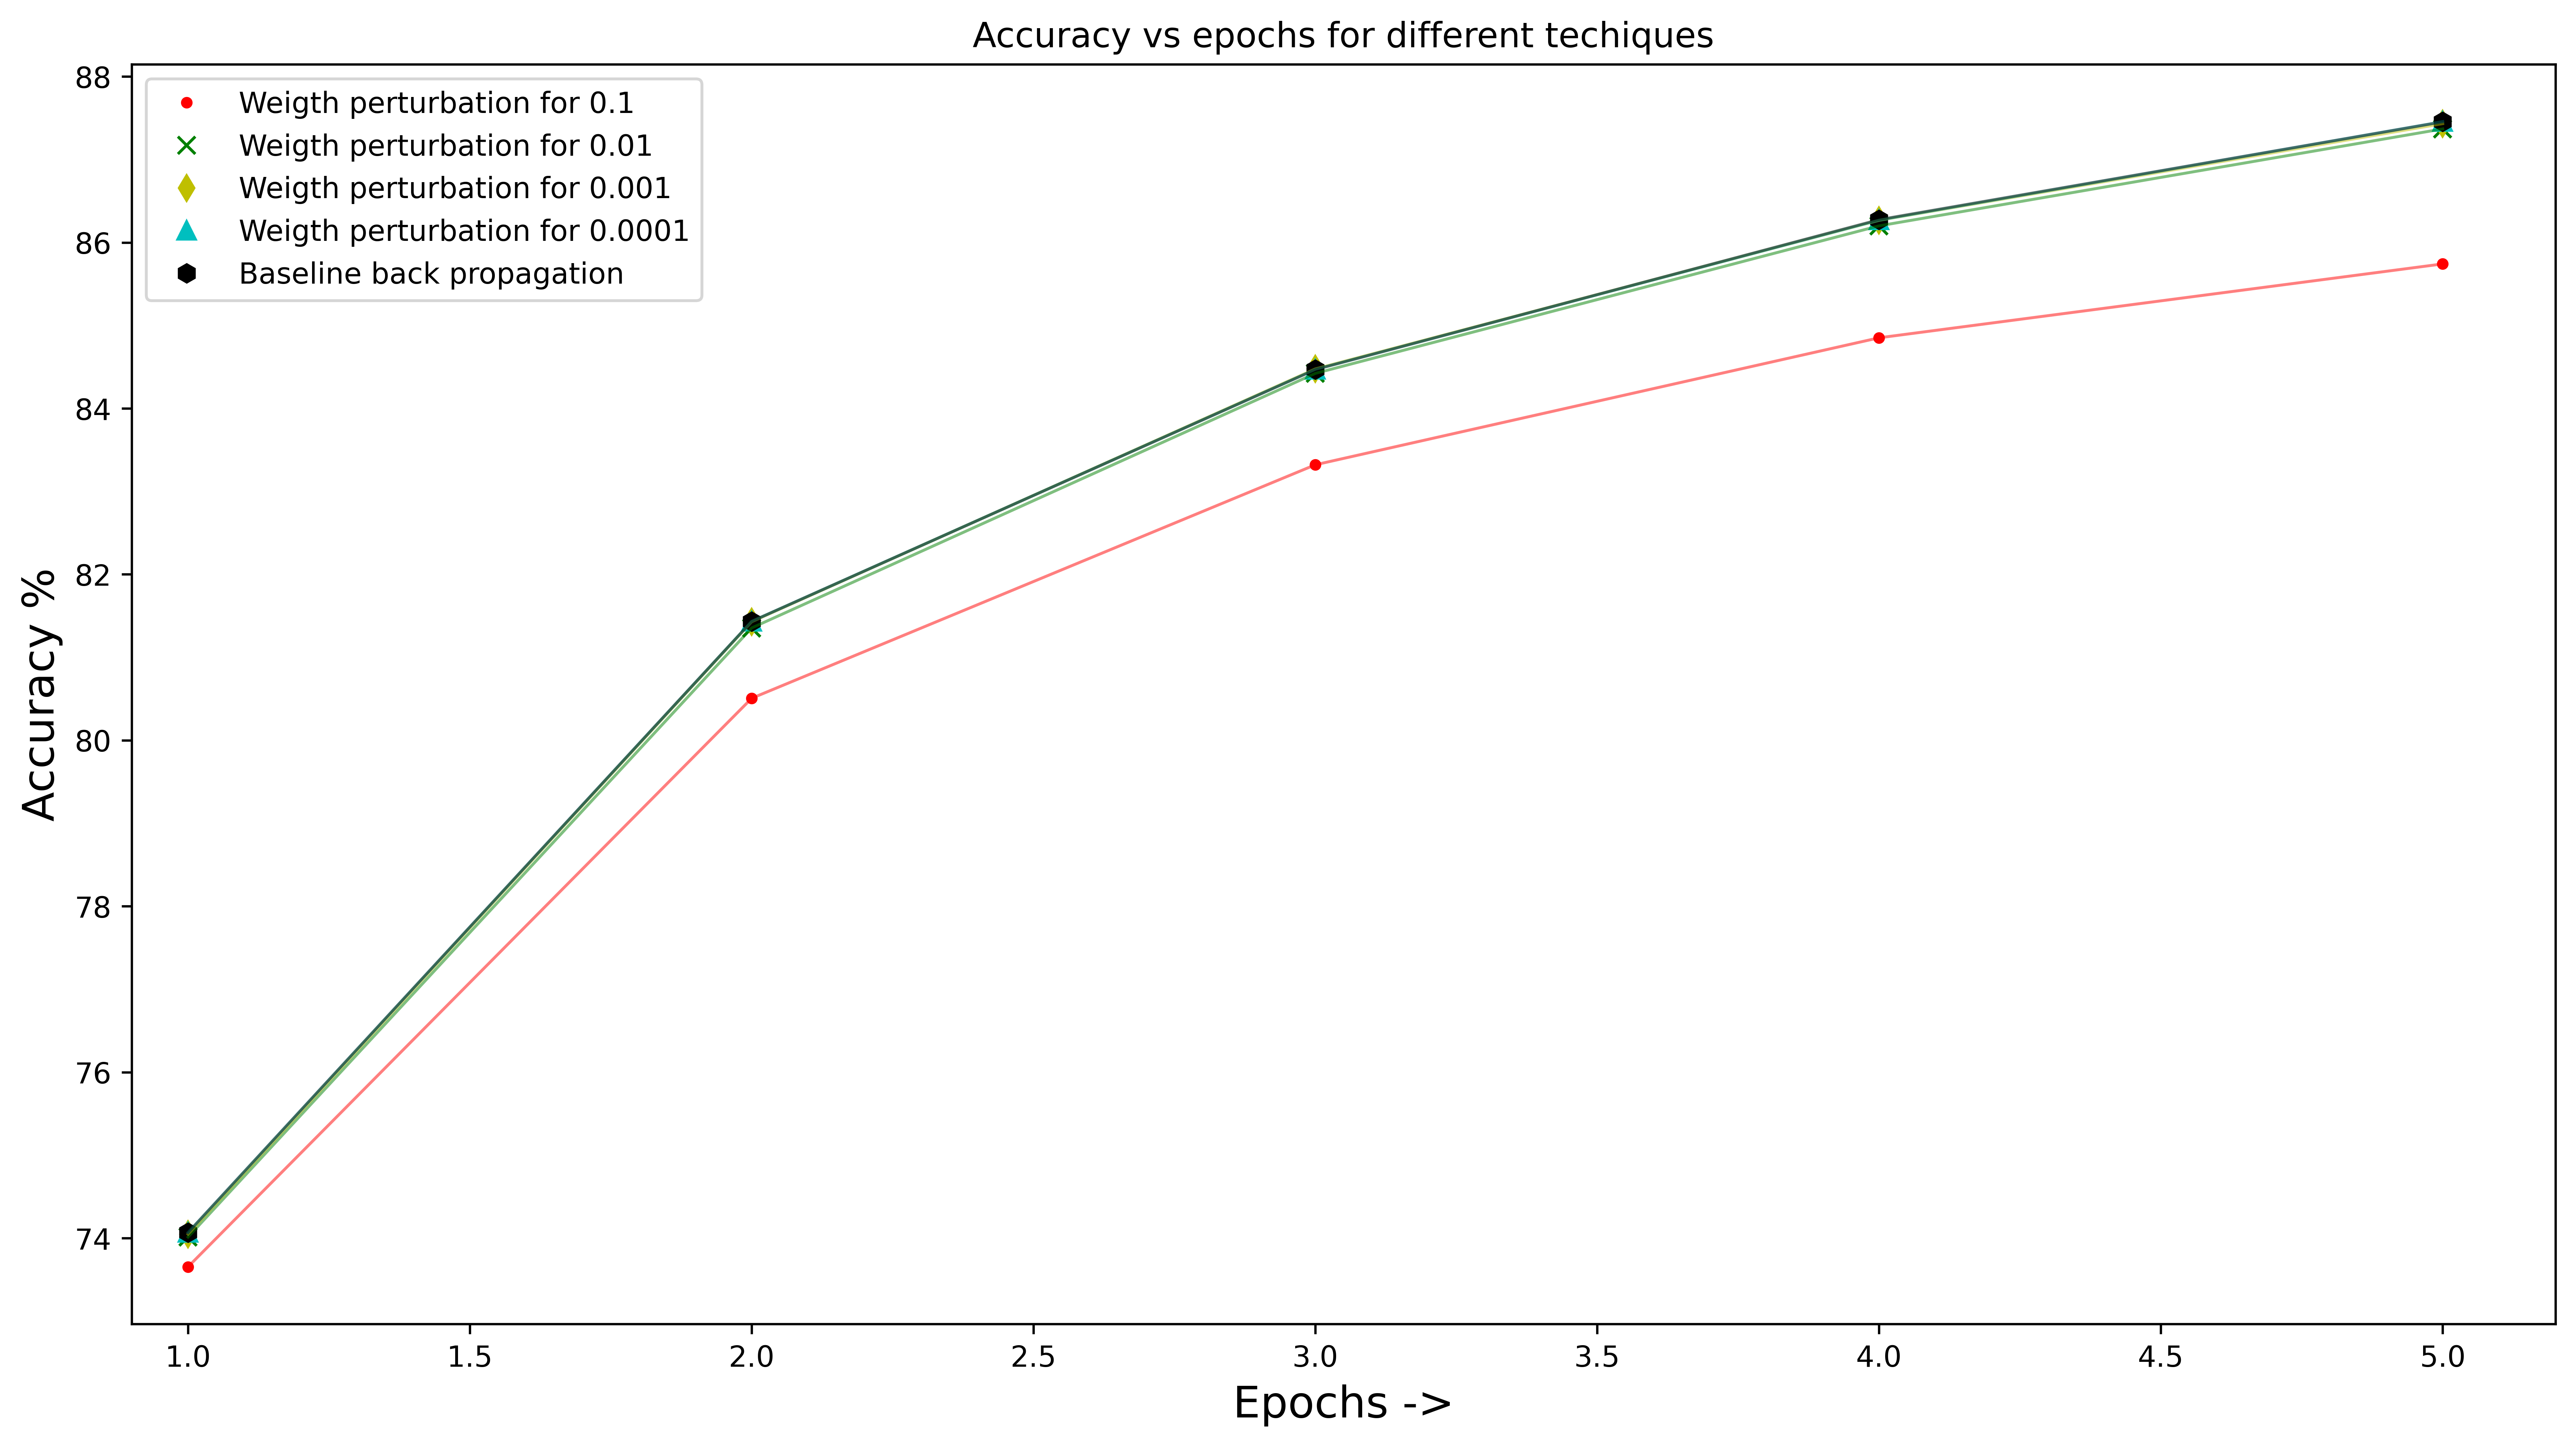

In [ ]:
plt.rcParams['figure.dpi'] = 600
plt.figure(figsize=(15, 8))
format = ['r.', 'gx', 'yd', 'c^']
col = ['r', 'g', 'y', 'c']
leg = []
epochList = [i+1 for i in range(5)]
for _ in range(len(pertList)):
    plt.plot(epochList, trainAccWP[_], format[_])
    leg.append(f"Weigth perturbation for {pertList[_]}")
plt.plot(epochList, train_accBP, 'kh')
leg.append("Baseline back propagation")
for _ in range(len(pertList)):
    plt.plot(epochList, trainAccWP[_], col[_], linewidth=1, alpha = 0.5)
plt.plot(epochList, train_accBP, 'k', linewidth=1, alpha = 0.5)
plt.legend(leg)
plt.xlim(left = 0.9)
plt.xlabel("Epochs ->", size = 15)
plt.ylabel("Accuracy %", size = 15)
plt.title("Accuracy vs epochs for different techiques")

Text(0.5, 1.0, 'Accuracy vs epochs for different techiques')

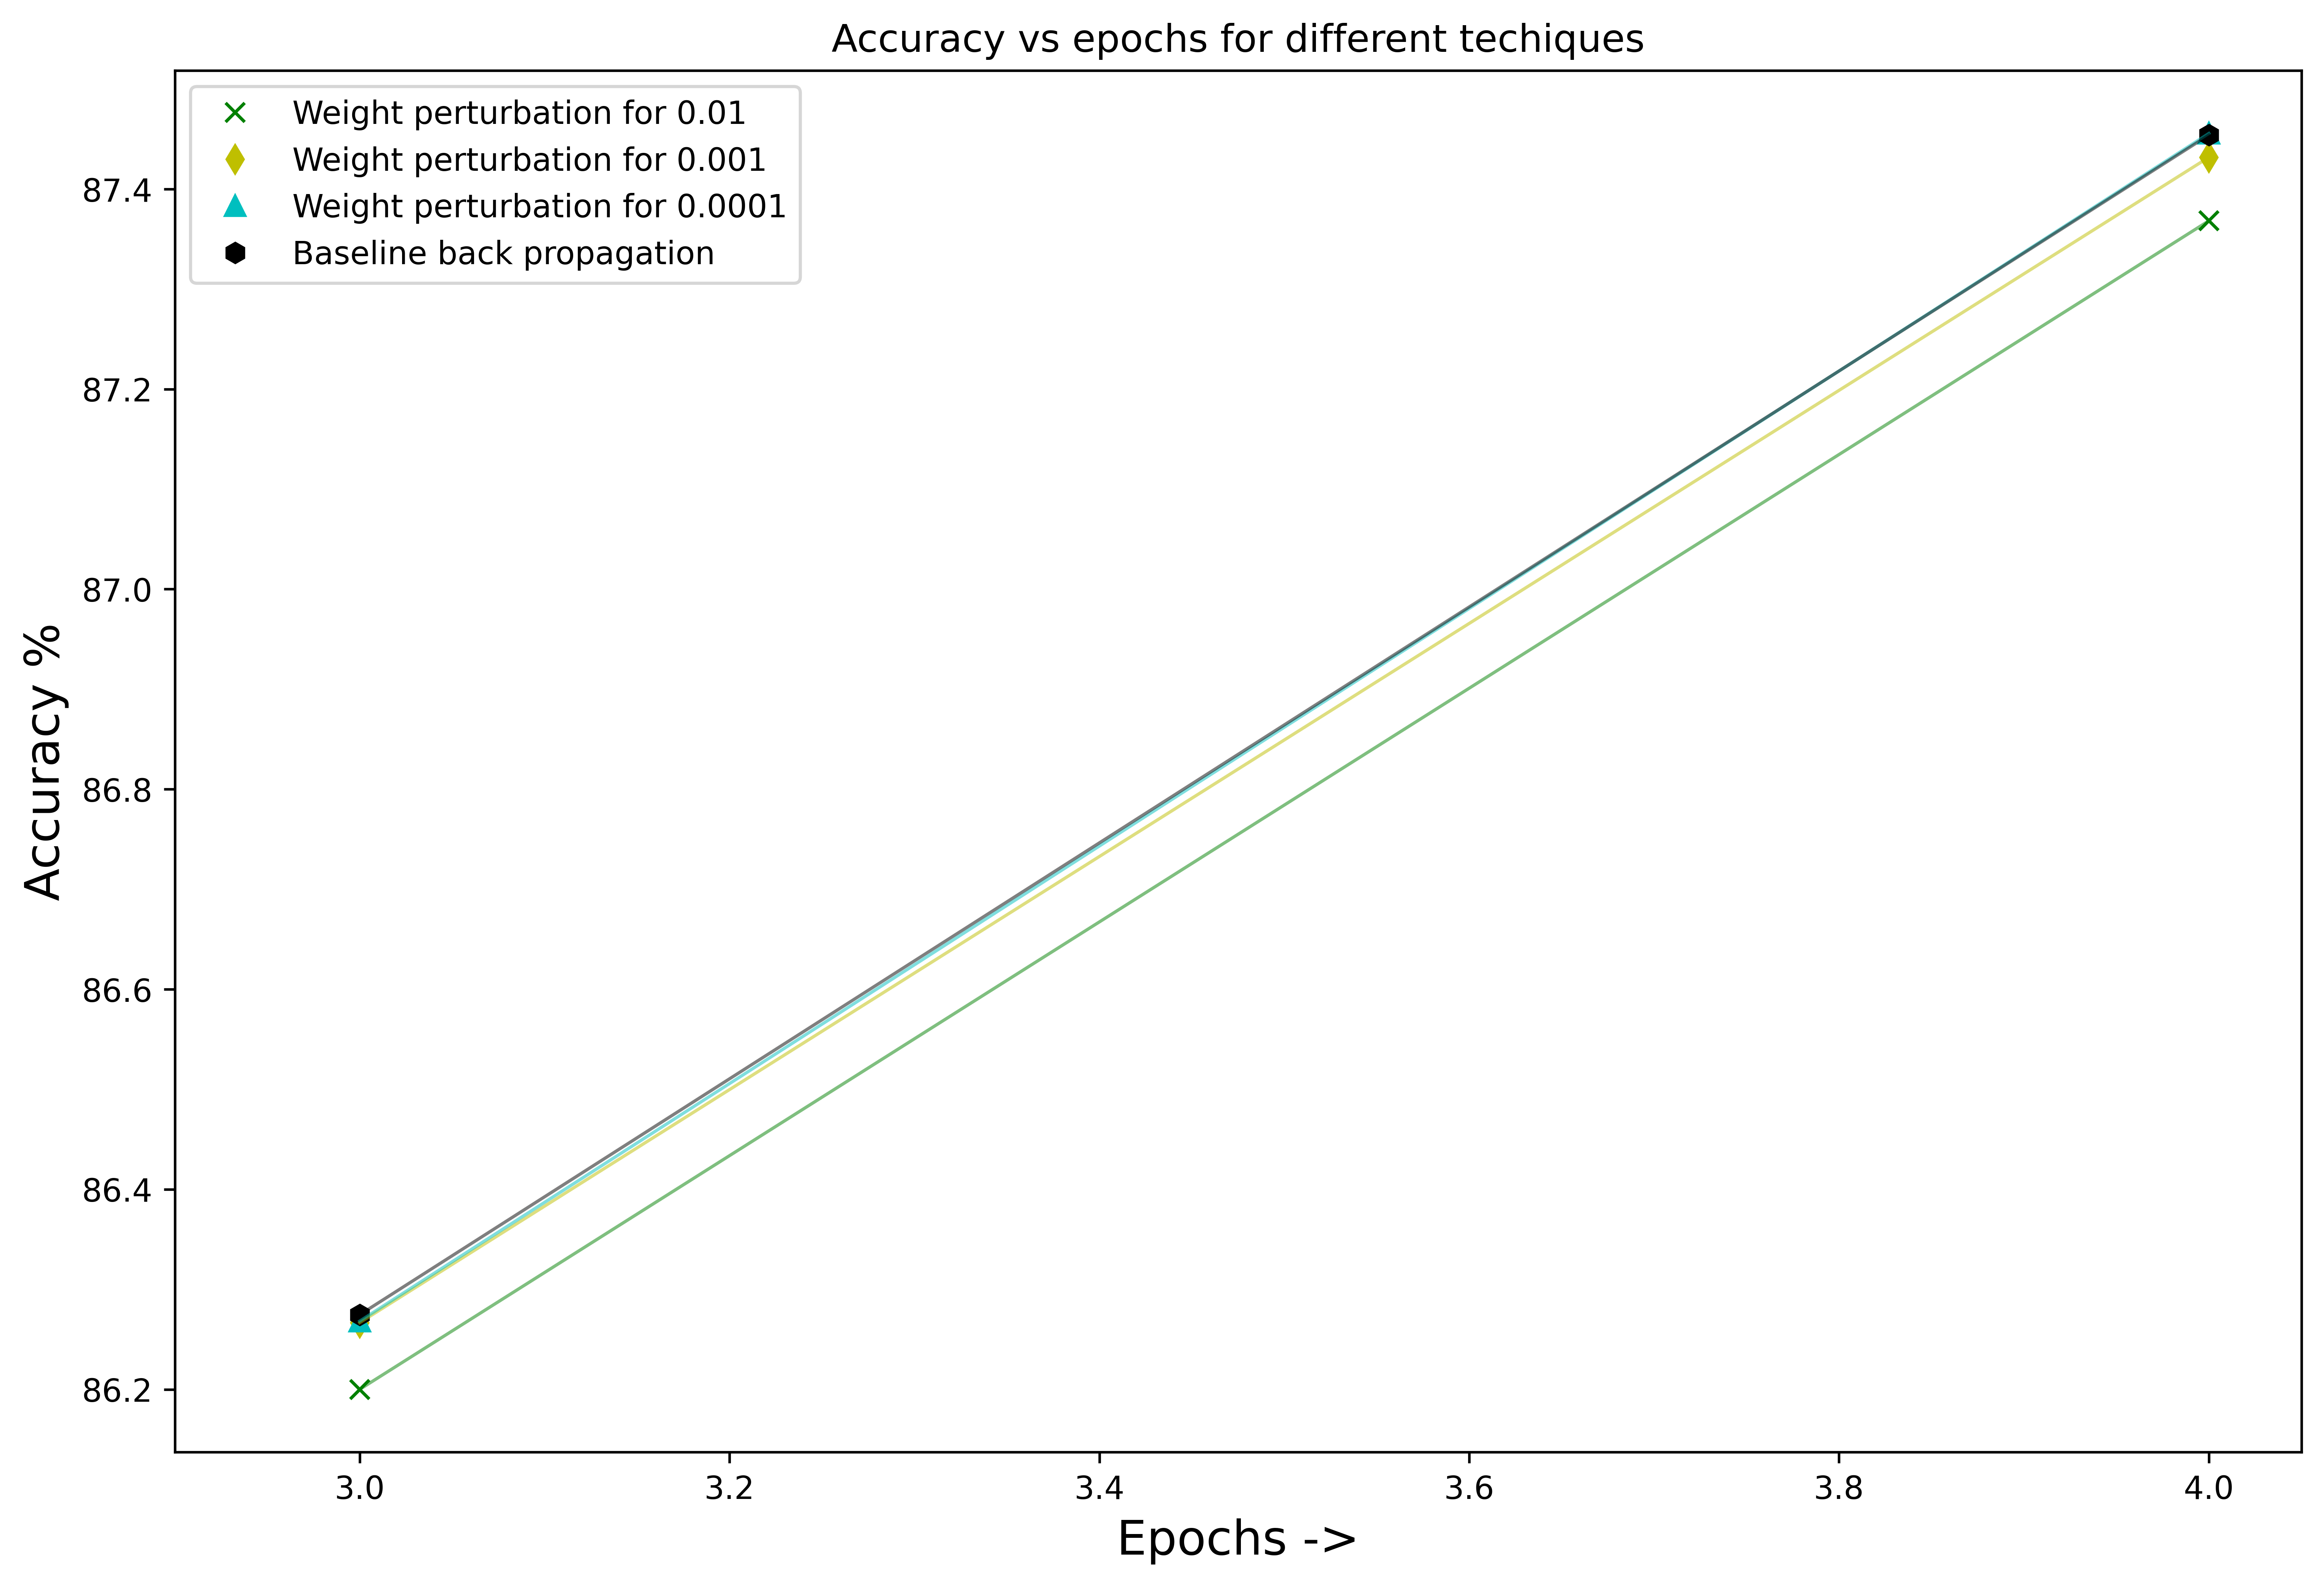

In [ ]:
plt.rcParams['figure.dpi'] = 600
plt.figure(figsize=(12, 8))
format = ['r.', 'gx', 'yd', 'c^']
col = ['r', 'g', 'y', 'c']
leg = []
epochList = [i for i in range(5)]
for _ in range(1, len(pertList)):
    plt.plot(epochList[3:], trainAccWP[_][3:], format[_])
    leg.append(f"Weight perturbation for {pertList[_]}")
plt.plot(epochList[3:], train_accBP[3:], 'kh')
leg.append("Baseline back propagation")
for _ in range(1, len(pertList)):
    plt.plot(epochList[3:], trainAccWP[_][3:], col[_], linewidth=1, alpha = 0.5)
plt.plot(epochList[3:], train_accBP[3:], 'k', linewidth=1, alpha = 0.5)
plt.legend(leg)
plt.xlim(left = 2.9)
plt.xlabel("Epochs ->", size = 15)
plt.ylabel("Accuracy %", size = 15)
plt.title("Accuracy vs epochs for different techiques")

## Adding variabilty

### Generic functions related to variability

In [14]:
#helps in rounding to the nearest integer multiples of the chosen 'step' value!
def roundArbitrary(weightArray, step):
  weightArrayDiv = weightArray / step
  weightArrayDiv = np.round(weightArrayDiv)
  return weightArrayDiv*step

In [15]:
def getVth(mu, sigma, shape):
  #last dimension represents the binary rep for each weight
  return np.random.normal(loc=mu, scale=sigma, size=shape) #each bit is represented by an sram so we need those many vth values for each mosfet in this set

In [16]:
def initMosParam(shape, mu, sigma, vDD, precision):
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)

    Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 

    iOn = ((vDD - Vth)**2)*1e-06#scaling the current according to Ioff values arbitraryfor now!!


    iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))


    iOff = np.random.uniform(low=0, high=1e-6, size = sizeI)#no negative value
    return (iOn, iOnNominal, iOff)

In [17]:
def clippedWeight(weightArray, precision, step, discreteSteps):
    return np.multiply(np.sign(weightArray), np.digitize(np.abs(weightArray), discreteSteps))*step

In [18]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray += np.multiply(np.sign(weightArray),  np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel))



  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [19]:
# refer to https://stackoverflow.com/questions/9958506/element-wise-string-concatenation-in-numpy

## NEED TO CORRECT IT FOR A NEGATIVE VALUES OF THE WEIGHT ARRAY!!!!
def weigthBitArray(weightArray, precision, discreteSteps):
    clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights

    iniArr = np.where(np.bitwise_and(clippedWeightIndexArray, 2**0)>=1, '1', '0') #array of bits at level 0 (2^0)

    for j in range(1, precision):
        iniArr = np.core.defchararray.add(np.where(np.bitwise_and(clippedWeightIndexArray, 2**j)>=1, '1', '0'), iniArr)
    return iniArr

In [20]:
def batchGDCompOC(X,Y,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, step, discreteSteps, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []
  W1comp = []

  W1, b1, W2, b2 = params_init(2)

  W1bp, b1bp, W2bp, b2bp= W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1bp, b1bp, W2bp, b2bp, W3bp, b3bp =params_init()

  W1wp, b1wp, W2wp, b2wp = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1np, b1np, W2np, b2np, W3np, b3np = params_init()


  W1Currents = initMosParam((20, 784), mu, sigma, vDD, precision)
  b1Currents = initMosParam((20, 1), mu, sigma, vDD, precision)
  W2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision)



  dW1Currents = initMosParam((20, 784), mu, sigma, vDD, precision)
  db1Currents = initMosParam((20, 1), mu, sigma, vDD, precision)
  dW2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision)
  db2Currents = initMosParam((10, 1), mu, sigma, vDD, precision)

  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    #computing the cosine similarity between the weights at eacj epoch
    # w1Sim.append(cosine_similarity(W1bp.reshape(1,-1), W1np.reshape(1,-1))[0][0])
    # b1Sim.append(cosine_similarity(b1bp.reshape(1,-1), b1np.reshape(1,-1))[0][0])
    # w2Sim.append(cosine_similarity(W2bp.reshape(1,-1), W2np.reshape(1,-1))[0][0])
    # b2Sim.append(cosine_similarity(b2bp.reshape(1,-1), b2np.reshape(1,-1))[0][0])
    # w3Sim.append(cosine_similarity(W3bp.reshape(1,-1), W3np.reshape(1,-1))[0][0])
    # b3Sim.append(cosine_similarity(b3bp.reshape(1,-1), b3np.reshape(1,-1))[0][0])

    print(cosine_similarity(W1bp.reshape(1,-1), W1wp.reshape(1,-1))[0][0])
    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      W1varocwp = weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps)
      b1varocwp = weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps)
      W2varocwp = weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps)
      b2varocwp = weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps)

      #W1comp.append([W1np[0, 0], W1varocwp[0, 0]])
      

      #print(W2varocwp)
      #doing the weight perturbation pass first
      Z1, A1, Z2, A2 = forward(X1, W1varocwp, b1varocwp, W2varocwp,b2varocwp) 
      #print(A2)
      print(f"WP Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1), 3)}", end = "\r", flush = True)
      #lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)
      lossBeforePert = np.sum(crossEntropy(one_hot_encoding(Y1), A2))

      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      #dW1np, db1np, dW2np, db2np, dW3np, db3np = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1varocnp, W2varocnp, W3varocnp,b1varocnp, b2varocnp, b3varocnp, X1, Y1)
      #print(f"iter in iter{j}")
      #dW1wp, db1wp, dW2wp, db2wp = WP(W1varocwp, b1varocwp, W2varocwp, b2varocwp, pert, lossBeforePert, X1, Y1)
      dW1wp, db1wp, dW2wp, db2wp = WP(W1wp, b1wp, W2wp, b2wp, pert, lossBeforePert, X1, Y1)


      dW1varocwp = weightTransformWithVariability(dW1wp, dW1Currents, precision, step, discreteSteps)
      db1varocwp = weightTransformWithVariability(db1wp.reshape(db1wp.shape[0],1), db1Currents, precision, step, discreteSteps)
      dW2varocwp = weightTransformWithVariability(dW2wp, dW2Currents, precision, step, discreteSteps)
      db2varocwp = weightTransformWithVariability(db2wp.reshape(db2wp.shape[0],1), db2Currents, precision, step, discreteSteps)



      W1wp, b1wp, W2wp, b2wp = param_update(W1wp, b1wp, W2wp,b2wp, dW1wp, db1wp, dW2wp, db2wp, lr = lrNP)
      #print(W1wp)
      ###print(f"Max W1={np.max(np.abs(W1np))},b1={np.max(np.abs(b1np))},W2={np.max(np.abs(W2np))},b2={np.max(np.abs(b2np))},W3={np.max(np.abs(W3np))},b3={np.max(np.abs(b3np))}", end= 'r', flush=True)




      #doing the back propagation for the same data set sample

      W1varocbp = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps)
      b1varocbp = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps)
      W2varocbp = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps)
      b2varocbp = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps)

      Z1, A1, Z2, A2 = forward(X1, W1varocbp, b1varocbp, W2varocbp,b2varocbp) 
      print(f"                                                                        BP Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1),3)}", end = "\r", flush = True)
      #print(f"Main iter: {i} Sub iter : {j}\n")
      dW1bp, db1bp, dW2bp, db2bp = backprop(Z1, A1, Z2, A2, W1bp, W2bp, X1, Y1)
      #print(f"iter in iter{j}")


      dW1varocbp = weightTransformWithVariability(dW1bp, dW1Currents, precision, step, discreteSteps)
      db1varocbp = weightTransformWithVariability(db1bp.reshape(db1bp.shape[0],1), db1Currents, precision, step, discreteSteps)
      dW2varocbp = weightTransformWithVariability(dW2bp, dW2Currents, precision, step, discreteSteps)
      db2varocbp = weightTransformWithVariability(db2bp.reshape(db2bp.shape[0],1), db2Currents, precision, step, discreteSteps)


      W1bp, b1bp, W2bp, b2bp = param_update(W1bp, b1bp, W2bp, b2bp, dW1bp, db1bp, dW2bp, db2bp,  lr = lrBP)
      #plt.plot(dW1np.flatten(), dW1bp.flatten(), '.')
      #plt.xlabel("Weight updates from Node perturbation")
      #plt.ylabel("Weight updates from Back prop")
      #plt.show()


    #lrNP = lrNP*np.exp(-0.1)
    #lrBP = lrBP*np.exp(-0.1)

    if (i+1)%(print_op) == 0:
      #print(f'\nIteration: {i + 1}')

      #obtain training loss
      _, _, _, A2_train = forward(X, W1wp, b1wp, W2wp, b2wp)
      _, _, _, A2_train_bp = forward(X, W1bp, b1bp, W2bp, b2bp)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append([accuracy(predictions(A2_train_bp), Y), train_score])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,  A2_val = forward(x_val, W1wp, b1wp, W2wp, b2wp)
      _, _, _, A2_val_bp = forward(x_val, W1bp, b1bp, W2bp, b2bp)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append([accuracy(predictions(A2_val_bp), y_val), val_score])
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy: {round(train_score, 3)}::Val accuracy: {round(val_score, 3)}:#########################:Train Acc BP::{round(accuracy(predictions(A2_train_bp), Y), 3)} Val Acc BP::{round(accuracy(predictions(A2_val_bp), y_val), 3)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return train_acc, val_acc, train_loss, val_loss, sum_weights

In [21]:
iter=1
lrBP=0.01
lrNP=0.01
pert=0.01
mu = 0.7
sigma = 0.1
vDD = 5
precision = 10#setting the precision value of the calculations
wRange = 5
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps

## Plotting the extent of variability

In [114]:
Curr = initMosParam((1,1), mu, sigma, vDD, precision)

In [115]:
p =np.array([[-1.94385,5.64389], [3.14,4.545909]])
p = np.array([2.3])
p = np.array([i for i in np.arange(-5, 5.0, 0.1)])
p = p.reshape((10, 10))

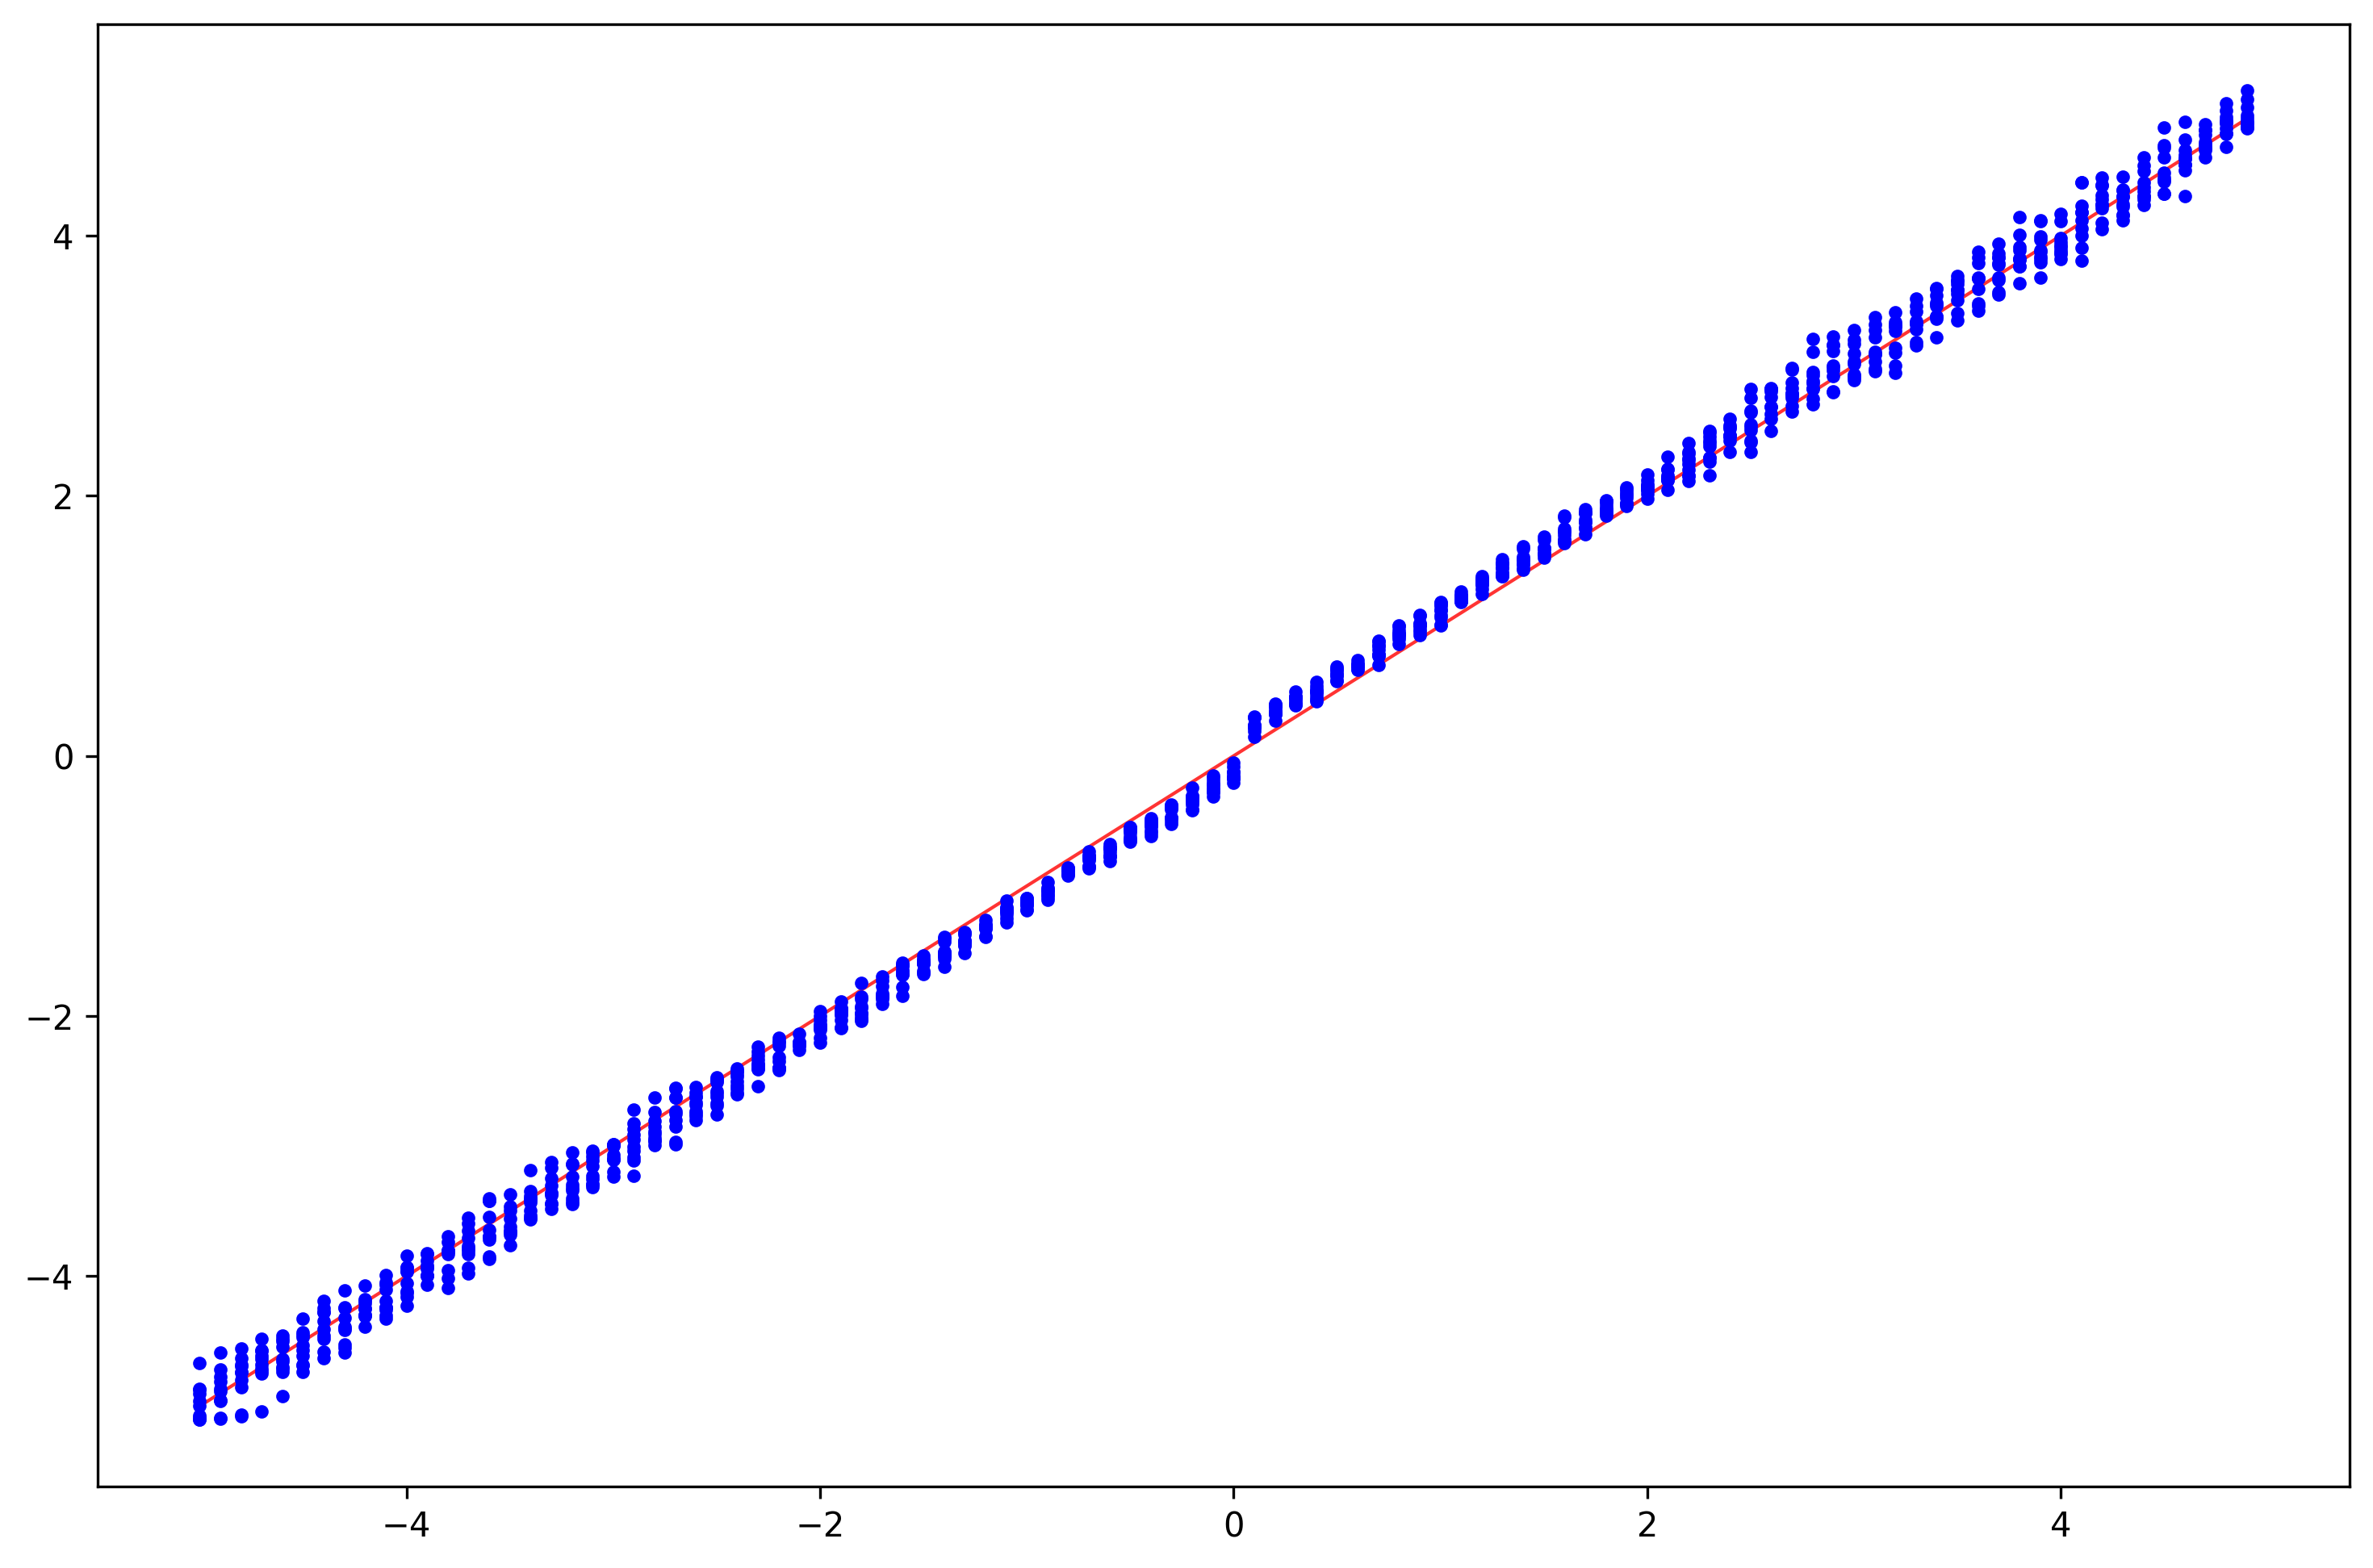

In [117]:
plt.figure(figsize=(12, 8))
plt.gcf().set_dpi(300)
plt.plot(p.flatten(), p.flatten(), 'r', linewidth=1, alpha = 0.8)
for _ in range(10):
    Curr = initMosParam((10,10), mu, sigma, vDD, precision)
    pVar = weightTransformWithVariability(p, Curr, precision, step, discreteSteps)
    plt.plot(p.flatten(), pVar.flatten(), 'b.')

In [53]:
pVarList = []
for _ in range(10000):
    Curr = initMosParam((1,1), mu, sigma, vDD, precision)
    pVar = weightTransformWithVariability(p, Curr, precision, step, discreteSteps)
    pVarList.append(pVar[0, 0])

ValueError: non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (1,1)

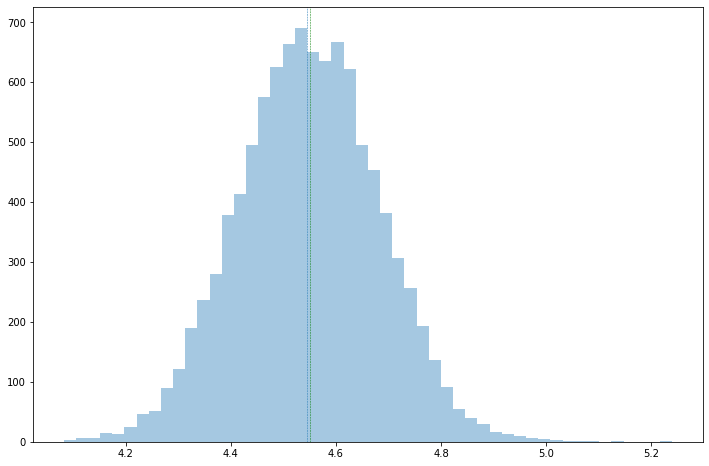

In [45]:
plt.figure(figsize=(12, 8))
plt.hist(pVarList, bins=50, alpha=0.4);
plt.axvline(p[1, 1], linestyle='--', linewidth=0.5)
plt.axvline(np.digitize(p[1, 1], discreteSteps)*step, color = 'g', linestyle='--', linewidth=0.5)

## Weight perturbation with variability(function needs update)

In [29]:
def WPwithVar(W1, b1, W2, b2, pert, lossBeforePert, X, y, precision, step, discreteSteps, W1Var, b1Var, W2Var, b2Var, W1Currents, b1Currents, W2Currents, b2Currents):
    assert pert==step #to get increments of '1' in the bit pattern of the weight array
    m = y.shape[0] #m is the number of training examples
    Y = one_hot_encoding(y)
    dW1 = np.zeros_like(W1)
    lossAfterPertW1 = np.zeros_like(W1)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1pert = roundArbitrary(W1.copy(), step)
            W1pert[i, j] += pert
            W1pertArrTr = weightTransformWithVariability(W1pert, W1Currents, precision, step, discreteSteps)
            _, _, _, A2pert = forward(X, W1pertArrTr, b1Var, W2Var, b2Var)
            lossAfterPertW1[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW1 = 1/m * (lossAfterPertW1-lossBeforePert)/pert


    db1 = np.zeros_like(b1)
    lossAfterPertb1 = np.zeros_like(b1)
    for i in range(b1.shape[0]):
        b1pert = roundArbitrary(b1.copy(), step)
        b1pert[i]+=pert
        b1pertArrTr = weightTransformWithVariability(b1pert, b1Currents, precision, step, discreteSteps)
        _, _, _, A2pert = forward(X, W1Var, b1pertArrTr, W2Var, b2Var)
        lossAfterPertb1[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db1 = 1/m * (lossAfterPertb1-lossBeforePert)/pert

    
    dW2 = np.zeros_like(W2)
    lossAfterPertW2 = np.zeros_like(W2)
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2pert = roundArbitrary(W2.copy(), step)
            W2pert[i, j] += pert
            W2pertArrTr = weightTransformWithVariability(W2pert, W2Currents, precision, step, discreteSteps)
            _, _, _, A2pert = forward(X, W1Var, b1Var, W2pertArrTr, b2Var)
            lossAfterPertW2[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW2 = 1/m * (lossAfterPertW2-lossBeforePert)/pert


    db2 = np.zeros_like(b2)
    lossAfterPertb2 = np.zeros_like(b2)
    for i in range(b2.shape[0]):
        b2pert = roundArbitrary(b2.copy(), step)
        b2pert[i]+=pert
        b2pertArrTr = weightTransformWithVariability(b2pert, b2Currents, precision, step, discreteSteps)
        _, _, _, A2pert = forward(X, W1Var, b1Var, W2Var, b2pertArrTr)
        lossAfterPertb2[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db2 = 1/m * (lossAfterPertb2-lossBeforePert)/pert

    return dW1, db1, dW2, db2
            

In [31]:
def batchGDCompOCUp(X,Y,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, step, discreteSteps, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []
  W1comp = []

  W1, b1, W2, b2 = params_init(2)

  W1bp, b1bp, W2bp, b2bp= W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1bp, b1bp, W2bp, b2bp, W3bp, b3bp =params_init()

  W1wp, b1wp, W2wp, b2wp = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1np, b1np, W2np, b2np, W3np, b3np = params_init()


  W1Currents = initMosParam((20, 784), mu, sigma, vDD, precision)
  b1Currents = initMosParam((20, 1), mu, sigma, vDD, precision)
  W2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision)



  dW1Currents = initMosParam((20, 784), mu, sigma, vDD, precision)
  db1Currents = initMosParam((20, 1), mu, sigma, vDD, precision)
  dW2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision)
  db2Currents = initMosParam((10, 1), mu, sigma, vDD, precision)

  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    #computing the cosine similarity between the weights at eacj epoch
    # w1Sim.append(cosine_similarity(W1bp.reshape(1,-1), W1np.reshape(1,-1))[0][0])
    # b1Sim.append(cosine_similarity(b1bp.reshape(1,-1), b1np.reshape(1,-1))[0][0])
    # w2Sim.append(cosine_similarity(W2bp.reshape(1,-1), W2np.reshape(1,-1))[0][0])
    # b2Sim.append(cosine_similarity(b2bp.reshape(1,-1), b2np.reshape(1,-1))[0][0])
    # w3Sim.append(cosine_similarity(W3bp.reshape(1,-1), W3np.reshape(1,-1))[0][0])
    # b3Sim.append(cosine_similarity(b3bp.reshape(1,-1), b3np.reshape(1,-1))[0][0])

    print(cosine_similarity(W1bp.reshape(1,-1), W1wp.reshape(1,-1))[0][0])
    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      W1varocwp = weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps)
      b1varocwp = weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps)
      W2varocwp = weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps)
      b2varocwp = weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps)

      #W1comp.append([W1np[0, 0], W1varocwp[0, 0]])
      

      #print(W2varocwp)
      #doing the weight perturbation pass first
      Z1, A1, Z2, A2 = forward(X1, W1varocwp, b1varocwp, W2varocwp,b2varocwp) 
      #print(A2)
      print(f"WP Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1), 3)}", end = "\r", flush = True)
      #lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)
      lossBeforePert = np.sum(crossEntropy(one_hot_encoding(Y1), A2))

      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      #dW1np, db1np, dW2np, db2np, dW3np, db3np = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1varocnp, W2varocnp, W3varocnp,b1varocnp, b2varocnp, b3varocnp, X1, Y1)
      #print(f"iter in iter{j}")
      #dW1wp, db1wp, dW2wp, db2wp = WP(W1varocwp, b1varocwp, W2varocwp, b2varocwp, pert, lossBeforePert, X1, Y1)
      dW1wp, db1wp, dW2wp, db2wp = WPwithVar(W1wp, b1wp, W2wp, b2wp, pert, lossBeforePert, X1, Y1, precision, step, discreteSteps, W1varocwp, b1varocwp, W2varocwp, b2varocwp, W1Currents, b1Currents, W2Currents, b2Currents)


      dW1varocwp = weightTransformWithVariability(dW1wp, dW1Currents, precision, step, discreteSteps)
      db1varocwp = weightTransformWithVariability(db1wp.reshape(db1wp.shape[0],1), db1Currents, precision, step, discreteSteps)
      dW2varocwp = weightTransformWithVariability(dW2wp, dW2Currents, precision, step, discreteSteps)
      db2varocwp = weightTransformWithVariability(db2wp.reshape(db2wp.shape[0],1), db2Currents, precision, step, discreteSteps)



      W1wp, b1wp, W2wp, b2wp = param_update(W1wp, b1wp, W2wp,b2wp, dW1wp, db1wp, dW2wp, db2wp, lr = lrNP)
      #print(W1wp)
      ###print(f"Max W1={np.max(np.abs(W1np))},b1={np.max(np.abs(b1np))},W2={np.max(np.abs(W2np))},b2={np.max(np.abs(b2np))},W3={np.max(np.abs(W3np))},b3={np.max(np.abs(b3np))}", end= 'r', flush=True)




      #doing the back propagation for the same data set sample

      W1varocbp = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps)
      b1varocbp = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps)
      W2varocbp = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps)
      b2varocbp = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps)

      Z1, A1, Z2, A2 = forward(X1, W1varocbp, b1varocbp, W2varocbp,b2varocbp) 
      print(f"                                                                        BP Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1),3)}", end = "\r", flush = True)
      #print(f"Main iter: {i} Sub iter : {j}\n")
      dW1bp, db1bp, dW2bp, db2bp = backprop(Z1, A1, Z2, A2, W1bp, W2bp, X1, Y1)
      #print(f"iter in iter{j}")


      dW1varocbp = weightTransformWithVariability(dW1bp, dW1Currents, precision, step, discreteSteps)
      db1varocbp = weightTransformWithVariability(db1bp.reshape(db1bp.shape[0],1), db1Currents, precision, step, discreteSteps)
      dW2varocbp = weightTransformWithVariability(dW2bp, dW2Currents, precision, step, discreteSteps)
      db2varocbp = weightTransformWithVariability(db2bp.reshape(db2bp.shape[0],1), db2Currents, precision, step, discreteSteps)


      W1bp, b1bp, W2bp, b2bp = param_update(W1bp, b1bp, W2bp, b2bp, dW1bp, db1bp, dW2bp, db2bp,  lr = lrBP)
      #plt.plot(dW1np.flatten(), dW1bp.flatten(), '.')
      #plt.xlabel("Weight updates from Node perturbation")
      #plt.ylabel("Weight updates from Back prop")
      #plt.show()


    #lrNP = lrNP*np.exp(-0.1)
    #lrBP = lrBP*np.exp(-0.1)

    if (i+1)%(print_op) == 0:
      #print(f'\nIteration: {i + 1}')

      #obtain training loss
      _, _, _, A2_train = forward(X, W1wp, b1wp, W2wp, b2wp)
      _, _, _, A2_train_bp = forward(X, W1bp, b1bp, W2bp, b2bp)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append([accuracy(predictions(A2_train_bp), Y), train_score])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,  A2_val = forward(x_val, W1wp, b1wp, W2wp, b2wp)
      _, _, _, A2_val_bp = forward(x_val, W1bp, b1bp, W2bp, b2bp)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append([accuracy(predictions(A2_val_bp), y_val), val_score])
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy: {round(train_score, 3)}::Val accuracy: {round(val_score, 3)}:#########################:Train Acc BP::{round(accuracy(predictions(A2_train_bp), Y), 3)} Val Acc BP::{round(accuracy(predictions(A2_val_bp), y_val), 3)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return train_acc, val_acc, train_loss, val_loss, sum_weights

In [32]:
trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,5, lrBP, lrNP, step, mu, sigma, vDD, precision, step, discreteSteps, print_op=1)

Params Initialised
0.999999999999999


## Plotting the effect of variability on sample weights

In [38]:
step

0.004887585532746823

In [95]:
wA = np.random.rand(1000, 1000)*5 - 2.5
wA

array([[-0.70414916,  1.27479926,  0.92167425, ...,  1.91384639,
        -1.8180515 , -0.47962124],
       [ 1.45252279, -2.07195048,  2.30315279, ..., -2.42895111,
         1.0534437 , -1.77370862],
       [ 0.97454122, -1.32269075,  2.13764839, ..., -0.47619093,
        -2.11406633,  0.09020027],
       ...,
       [-0.01821392, -1.04131977, -0.56875445, ..., -1.8319717 ,
        -1.91327223,  1.73114256],
       [ 1.72186701,  1.5440023 ,  0.15994341, ...,  1.03188012,
         2.36428389, -1.24520087],
       [-0.78462917, -0.0388239 , -0.85533215, ..., -0.69864365,
         0.27096892, -0.24115267]])

In [96]:
np.digitize(np.abs(wA), discreteSteps)

array([[145, 261, 189, ..., 392, 372,  99],
       [298, 424, 472, ..., 497, 216, 363],
       [200, 271, 438, ...,  98, 433,  19],
       ...,
       [  4, 214, 117, ..., 375, 392, 355],
       [353, 316,  33, ..., 212, 484, 255],
       [161,   8, 176, ..., 143,  56,  50]], dtype=int64)

In [97]:
start = time.time()
print(weigthBitArray(wA, precision,discreteSteps)[0])
end = time.time()
#print(end-start)

['0010010001' '0100000101' '0010111101' '0010111000' '0011000001'
 '0110100000' '0000010001' '0100001000' '0010110001' '0011000001'
 '0100010111' '0001011101' '0001001100' '0011111101' '0101011011'
 '0100011000' '0011000011' '0101000111' '0011100011' '0011101000'
 '0110010110' '0110101001' '0001010111' '0010111111' '0001001111'
 '0100100101' '0010100100' '0001000000' '0101000010' '0101111011'
 '0011000011' '0010100000' '0001010011' '0011110011' '0111011101'
 '0111010101' '0010110000' '0001010000' '0110011100' '0001100001'
 '0011011110' '0111010001' '0111111111' '0101111110' '0000111110'
 '0010001111' '0001101111' '0110011000' '0000111110' '0010101110'
 '0110101001' '0101001000' '0011101011' '0011011111' '0111101000'
 '0100110000' '0010010100' '0010100100' '0001001001' '0010001000'
 '0111010001' '0101000110' '0001101101' '0111010000' '0110000110'
 '0111000000' '0001001000' '0101010001' '0000100101' '0101101010'
 '0111101111' '0010001001' '0110011011' '0101011000' '0110011100'
 '00010101

In [98]:
#curr = initMosParam((1000, 1000), mu, sigma, vDD, precision)
wAT = clippedWeight(wA, precision, step, discreteSteps)
wAT

array([[-0.7086999 ,  1.27565982,  0.92375367, ...,  1.91593353,
        -1.81818182, -0.48387097],
       [ 1.45650049, -2.07233627,  2.30694037, ..., -2.42913001,
         1.05571848, -1.77419355],
       [ 0.97751711, -1.32453568,  2.14076246, ..., -0.47898338,
        -2.11632454,  0.09286413],
       ...,
       [-0.01955034, -1.0459433 , -0.57184751, ..., -1.83284457,
        -1.91593353,  1.73509286],
       [ 1.72531769,  1.54447703,  0.16129032, ...,  1.03616813,
         2.3655914 , -1.24633431],
       [-0.78690127, -0.03910068, -0.86021505, ..., -0.69892473,
         0.27370479, -0.24437928]])

In [99]:
print(weigthBitArray(wAT, precision,discreteSteps)[0])

['0010010010' '0100000110' '0010111110' '0010111001' '0011000010'
 '0110100001' '0000010010' '0100001001' '0010110010' '0011000010'
 '0100011000' '0001011110' '0001001101' '0011111110' '0101011100'
 '0100011001' '0011000100' '0101001000' '0011100100' '0011101001'
 '0110010111' '0110101010' '0001011000' '0011000000' '0001010000'
 '0100100110' '0010100101' '0001000001' '0101000011' '0101111100'
 '0011000100' '0010100001' '0001010100' '0011110100' '0111011110'
 '0111010110' '0010110001' '0001010001' '0110011101' '0001100010'
 '0011011111' '0111010010' '1000000000' '0101111111' '0000111111'
 '0010010000' '0001110000' '0110011001' '0000111111' '0010101111'
 '0110101010' '0101001001' '0011101100' '0011100000' '0111101001'
 '0100110001' '0010010101' '0010100101' '0001001010' '0010001001'
 '0111010010' '0101000111' '0001101110' '0111010001' '0110000111'
 '0111000001' '0001001001' '0101010010' '0000100110' '0101101011'
 '0111110000' '0010001010' '0110011100' '0101011001' '0110011101'
 '00010101

In [106]:
wAT[0, 1] += step

In [107]:
wAT[0, 1]/step

262.0

In [108]:
wAT

array([[-0.70381232,  1.28054741,  0.92375367, ...,  1.91593353,
        -1.81818182, -0.48387097],
       [ 1.45650049, -2.07233627,  2.30694037, ..., -2.42913001,
         1.05571848, -1.77419355],
       [ 0.97751711, -1.32453568,  2.14076246, ..., -0.47898338,
        -2.11632454,  0.09286413],
       ...,
       [-0.01955034, -1.0459433 , -0.57184751, ..., -1.83284457,
        -1.91593353,  1.73509286],
       [ 1.72531769,  1.54447703,  0.16129032, ...,  1.03616813,
         2.3655914 , -1.24633431],
       [-0.78690127, -0.03910068, -0.86021505, ..., -0.69892473,
         0.27370479, -0.24437928]])

In [109]:
np.digitize(np.abs(wAT), discreteSteps)

array([[145, 263, 190, ..., 393, 373, 100],
       [299, 425, 473, ..., 498, 217, 364],
       [201, 272, 439, ...,  99, 434,  20],
       ...,
       [  5, 215, 118, ..., 376, 393, 356],
       [354, 317,  34, ..., 213, 485, 256],
       [162,   9, 177, ..., 144,  57,  51]], dtype=int64)

In [110]:
start = time.time()
print(weigthBitArray(wAT, precision,discreteSteps)[0])
end = time.time()

['0010010001' '0100000111' '0010111110' '0010111001' '0011000010'
 '0110100001' '0000010010' '0100001001' '0010110010' '0011000010'
 '0100011000' '0001011110' '0001001101' '0011111110' '0101011100'
 '0100011001' '0011000100' '0101001000' '0011100100' '0011101001'
 '0110010111' '0110101010' '0001011000' '0011000000' '0001010000'
 '0100100110' '0010100101' '0001000001' '0101000011' '0101111100'
 '0011000100' '0010100001' '0001010100' '0011110100' '0111011110'
 '0111010110' '0010110001' '0001010001' '0110011101' '0001100010'
 '0011011111' '0111010010' '1000000000' '0101111111' '0000111111'
 '0010010000' '0001110000' '0110011001' '0000111111' '0010101111'
 '0110101010' '0101001001' '0011101100' '0011100000' '0111101001'
 '0100110001' '0010010101' '0010100101' '0001001010' '0010001001'
 '0111010010' '0101000111' '0001101110' '0111010001' '0110000111'
 '0111000001' '0001001001' '0101010010' '0000100110' '0101101011'
 '0111110000' '0010001010' '0110011100' '0101011001' '0110011101'
 '00010101

In [111]:
np.digitize(np.array([3.45, 5.6890]), [1, 2, 3, 4, 5, 6])

array([3, 5], dtype=int64)

In [119]:
np.digitize(np.array([0.34, 3.785, 8.6890]), [0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6])-1

array([0, 4, 7], dtype=int64)

In [134]:
roundArbitrary(np.array([0.001, 3.785, 8.6890]), step)

array([0.        , 3.7829912 , 8.69012708])

In [22]:
cc = np.random.rand(1000, 1000)
cc

array([[0.52830469, 0.64284221, 0.22946088, ..., 0.95870174, 0.313823  ,
        0.35551412],
       [0.67196061, 0.06590404, 0.64283862, ..., 0.24175304, 0.18333811,
        0.84114792],
       [0.37304342, 0.69461971, 0.16498704, ..., 0.05277978, 0.6405767 ,
        0.21697348],
       ...,
       [0.44404032, 0.84922377, 0.70579192, ..., 0.14700303, 0.72727405,
        0.91841524],
       [0.55140881, 0.22599842, 0.8401838 , ..., 0.19615833, 0.61295631,
        0.96028398],
       [0.54549088, 0.1461275 , 0.76429133, ..., 0.03837898, 0.07458539,
        0.19601376]])

In [23]:
fa = roundArbitrary(cc, step)
fa

array([[0.52785924, 0.64516129, 0.22971652, ..., 0.95796676, 0.31280547,
        0.35679374],
       [0.66959922, 0.06353861, 0.64516129, ..., 0.23949169, 0.18572825,
        0.84066471],
       [0.3714565 , 0.69403715, 0.16617791, ..., 0.05376344, 0.6402737 ,
        0.21505376],
       ...,
       [0.44477028, 0.85043988, 0.70381232, ..., 0.14662757, 0.72825024,
        0.91886608],
       [0.55229717, 0.22482893, 0.84066471, ..., 0.19550342, 0.61094819,
        0.95796676],
       [0.54740958, 0.14662757, 0.76246334, ..., 0.03910068, 0.07331378,
        0.19550342]])

In [24]:
weigthBitArray(fa, precision, discreteSteps)

array([['0001101101', '0010000101', '0000110000', ..., '0011000101',
        '0001000001', '0001001010'],
       ['0010001010', '0000001110', '0010000101', ..., '0000110010',
        '0000100111', '0010101101'],
       ['0001001101', '0010001111', '0000100011', ..., '0000001100',
        '0010000100', '0000101101'],
       ...,
       ['0001011100', '0010101111', '0010010001', ..., '0000011111',
        '0010010110', '0010111101'],
       ['0001110010', '0000101111', '0010101101', ..., '0000101001',
        '0001111110', '0011000101'],
       ['0001110001', '0000011111', '0010011101', ..., '0000001001',
        '0000010000', '0000101001']], dtype='<U10')

In [27]:
fa[0, 0] += step

In [28]:
weigthBitArray(fa, precision, discreteSteps)

array([['0001101111', '0010000101', '0000110000', ..., '0011000101',
        '0001000001', '0001001010'],
       ['0010001010', '0000001110', '0010000101', ..., '0000110010',
        '0000100111', '0010101101'],
       ['0001001101', '0010001111', '0000100011', ..., '0000001100',
        '0010000100', '0000101101'],
       ...,
       ['0001011100', '0010101111', '0010010001', ..., '0000011111',
        '0010010110', '0010111101'],
       ['0001110010', '0000101111', '0010101101', ..., '0000101001',
        '0001111110', '0011000101'],
       ['0001110001', '0000011111', '0010011101', ..., '0000001001',
        '0000010000', '0000101001']], dtype='<U10')

NameError: name 'batchGDCompOCUp' is not defined